# Making Own Mock Data
The last bit of mock data that was tried (in `work-with-true.ipynb`) already contained selection effects that distorted the 35M$_\odot$ bump that the code was trying to pin down. To see if the algorithm can even handle it at all and to see what the selection effects do to the analysis, mock data data without selection effects need to be generated and tested, which is what we're doing here

In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as con
from astropy import cosmology as cosmo
from astropy.cosmology import Planck18
from scipy.integrate import quad
from tqdm import tqdm
import warnings
from scipy import integrate
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

%matplotlib inline

## Generating data points

In [2]:
# Parameters:

N = int(1E4) # Number of data points

### Mass function: all mass in units of M_sun
m_scale = -2.35 # exponent in exponential function
m_min = 5 # minimum mass
m_max = 100 # maximum mass
m_bump = 35 # location of bump
sigma_bump = 5 # width of bump

frac_bump = 0.3 # fraction of BH in bump

zmax = 5
dl_max = Planck18.luminosity_distance(zmax)

In [3]:
def P_m(m, alpha=m_scale, mmin=m_min):
    '''Converts X~Uniform[0,1] to bounded Power law with slope alpha and min value m_min'''    
    ma = mmin**alpha
    return (ma + (-ma)*m)**(1/alpha)

def generate_masses(N_samples=N, f=frac_bump, m_b=m_bump, sigma=sigma_bump, alpha=m_scale, mmin=m_min):
    '''Generate masses based on mass function for black holes.
       Distribution follows power law with gaussian bump, tunable with arguments'''
    
    mass_array = np.zeros(N_samples)
    in_bump = np.random.rand(N_samples) < f #pick which distribution each point goes in

    for i, point in enumerate(in_bump):
        if point: #if point is going into the bump distribution
            # random seed
            mass_array[i] = np.random.normal(m_b, sigma)

        else: # going into exponential instead
            mass_array[i] = P_m(np.random.rand(), alpha=alpha, mmin=mmin)
    return mass_array

def generate_dLs(N_samples=N, R=dl_max):
    '''Sample from uniform sphere of radius R'''
    return np.cbrt(np.random.rand(N_samples))*R.value

def dLs_to_zs(dLs, cosmology=Planck18):
    '''returns array of zs for corresponding dLs'''
    return np.array([cosmo.z_at_value(Planck18.luminosity_distance, x*u.Mpc).value for x in dLs])

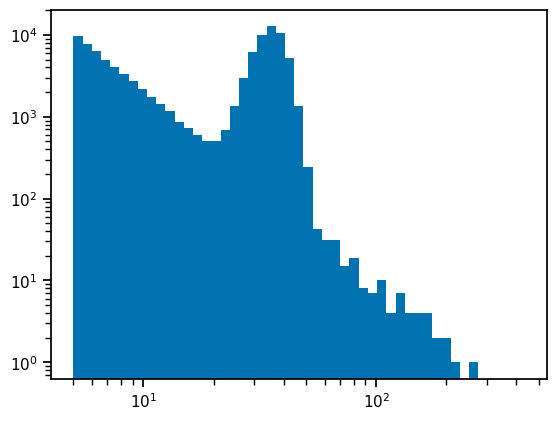

In [4]:
### Plotting Mass Function just to make sure it works properly

samples = generate_masses(int(1E5), f=0.5)

plt.hist(samples, bins=np.logspace(np.log10(5), np.log10(max(samples)), 50))
plt.yscale('log')
plt.xscale('log')

(array([  44.,  130.,  234.,  441.,  659.,  892., 1237., 1674., 2043.,
        2646.]),
 array([ 3264.48432689,  7705.61909986, 12146.75387283, 16587.8886458 ,
        21029.02341877, 25470.15819174, 29911.29296471, 34352.42773768,
        38793.56251065, 43234.69728362, 47675.83205659]),
 <BarContainer object of 10 artists>)

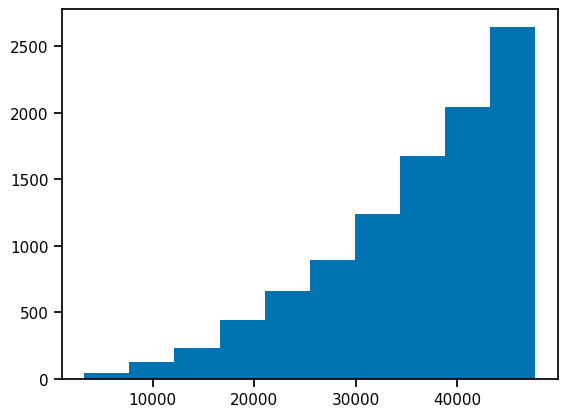

In [5]:
plt.hist(generate_dLs())

In [6]:
dLs = generate_dLs(100)

zs = dLs_to_zs(dLs)
# print(zs)

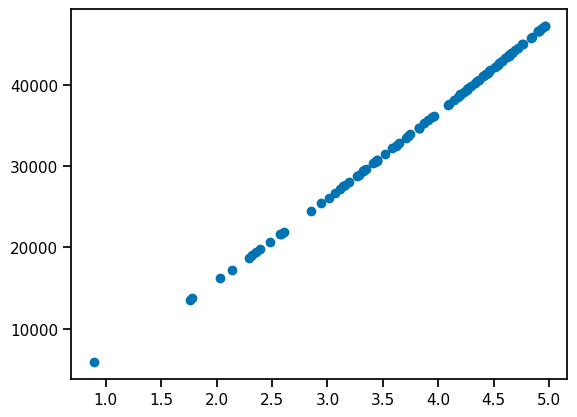

In [7]:
plt.scatter(zs, dLs)

## Analyzing synthesized population
Now that the functions are all in place for generating the data, lets synthesize a population to work with and see if the MCMC can reconstruct it

First step: generate the data we'll use:

In [18]:
ms = generate_masses()
d_Ls = generate_dLs()
zs = dLs_to_zs(d_Ls)

In [19]:
### Functions for implementing MCMC using PyMC4
### ...I should really just put them in a module so I don't have to keep copy/pasting...

def at_interp(x, xs, ys):
    '''Custom linear interpolator'''
    x  = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    n = xs.shape[0]
    
    ind = ate.searchsorted(xs, x)
    ind = at.where(ind >= n, n-1, ind)
    ind = at.where(ind < 0, 0, ind)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1]) 
    return r*ys[ind] + (1-r)*ys[ind-1]

def Ez(z, Om, w):
    '''Integrand in d_L z relation'''
    z = at.as_tensor(z)

#     w = at.as_tensor(w)
#     Om = at.as_tensor(Om)

    opz = 1 + z
    
    return at.sqrt(Om*opz*opz*opz + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w):
    '''Integrating over range of z'''
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w)
    I = 0.5*dz*(fz[:-1] + fz[1:]) #trapazoidally integrating
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    '''Combining constants and integral to get d_L'''
    return dCs*(1+zs)

def make_model(ms_obs, sigma_ms_obs, dls, zmin=0, zmax=100):
    '''Make PyMC4 MCMC model using custom helper functions'''
    zinterp = expm1(linspace(log(1+zmin), log(1+zmax), 1024))

    with pm.Model() as model:
        w = pm.Normal('w', mu=-1, sigma=0.25) 

        Om = pm.Bound('Om', pm.Normal.dist(mu=0.3, sigma=0.15), lower=0, upper=1)

        h = pm.Bound('h', pm.Lognormal.dist(mu=log(0.7), sigma=0.2), lower=0.35, upper=1.4)
#         h = pm.Lognormal('h', mu=log(0.7), sigma=0.2)
        Ode = pm.Deterministic('Ode', 1-Om)
        om = pm.Deterministic('om', Om*h*h)
        ode = pm.Deterministic('ode', Ode*h*h)

        dH= pm.Deterministic('dH', 2.99792/h)
        m0 = pm.Lognormal('m0', mu=log(35), sigma=0.5)

        dCinterp = dH*dCs(zinterp, Om, w)
        dLinterp = dLs(zinterp, dCinterp)
        
        zs = pm.Deterministic('zs', at_interp(dls, dLinterp, zinterp))

        pm.Normal('m_likelihood', mu=m0*(1+zs), sigma=sigma_ms_obs, observed=ms_obs)
    return model

def find_argmax_gridsearch(xs, fxs):
    '''Custom max finder for arrays'''
    imax = np.argmax(fxs)

    if imax == 0 or imax == len(xs)-1:
        warnings.warn('max occurs at grid boundary')
        return xs[imax]

    x0, x1, x2 = xs[imax-1], xs[imax], xs[imax+1]
    f0, f1, f2 = fxs[imax-1], fxs[imax], fxs[imax+1]

    dx01 = x0-x1
    dx12 = x1-x2
    dx20 = x2-x0

    sx01 = x0+x1
    sx12 = x1+x2
    sx20 = x2+x0

    xmax = (f2*dx01*sx01 + f0*dx12*sx12 + f1*dx20*sx20)/\
            (2*(f2*dx01 + f0*dx12 + f1*dx20))

    return xmax



81.8360559339665 3.9106385994032054 402.15684410736645
(10000,)


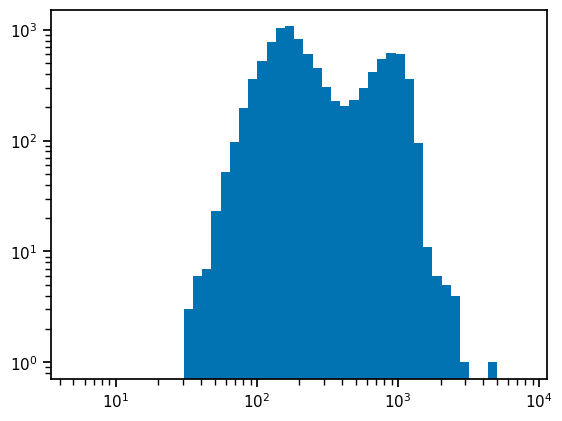

In [24]:
m_det = ms*(1+zs)
print(np.mean(ms), np.mean(zs), np.mean(m_det))
print(m1_det.shape)
plt.hist(m_det, bins=np.logspace(np.log10(5), np.log10(max(m_det)), 50))
plt.xscale('log')
plt.yscale('log')

100%|███████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.17s/it]


(0.0, 250.0)

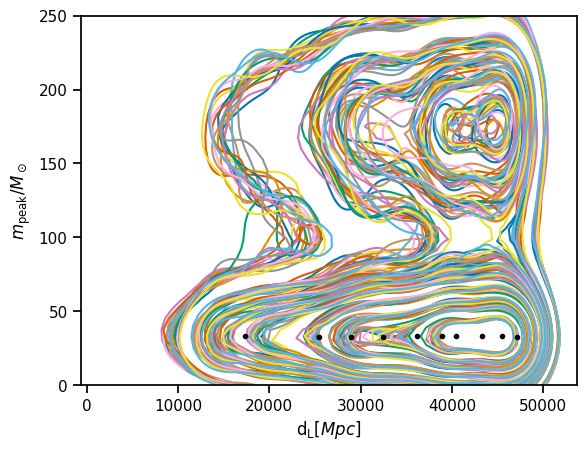

In [21]:
### Step 3:
n_events = len(m_det)
n_dLs=10
n_mc = 20
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(d_Ls)
dL_max = max(d_Ls)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(d_Ls, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    ms = m_det[events]
    d_Ls = d_Ls[events]
    
    arr = np.array([d_Ls, ms])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls, y=ms)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(0, 250)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9349, but should be close to 0.8. Try to increase the number of tuning steps.
There were 440 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1, but should be close to 0.8. Try to increase the number of tuning steps.


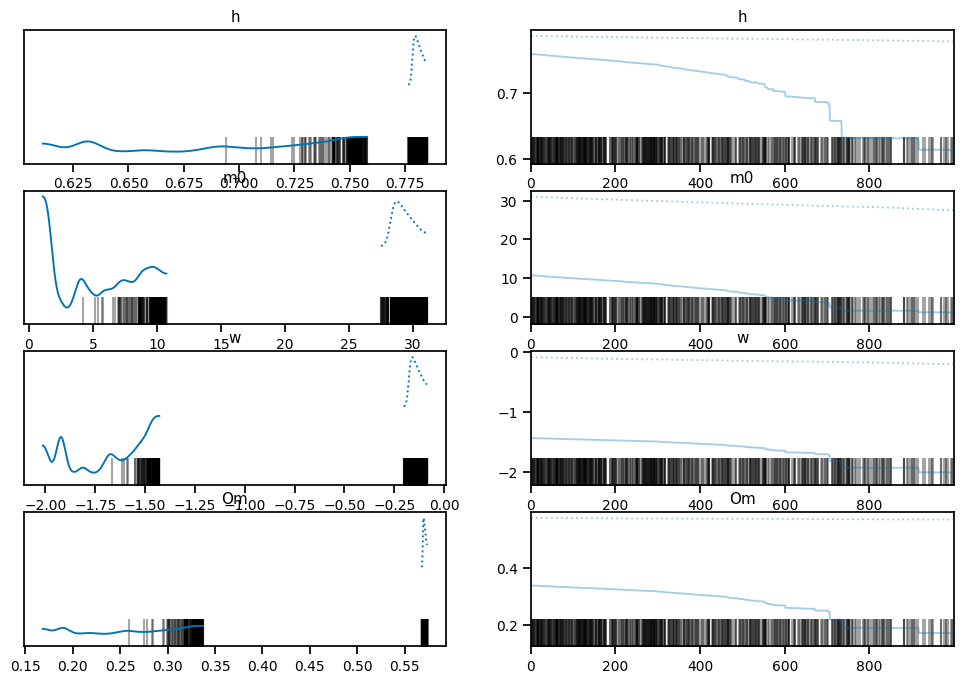

In [22]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = np.std(mpeak_samples, axis=0)

### Step 4:
with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m+0.25*mu_m, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace